In [1]:
import os
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random
import pandas as pd

Making the same data generator function as the code in Data_Generator.ipynb

In [2]:
def imageLoader(img_dir, img_list):
    images = []
    for fname in img_list:
        if fname.endswith('.npy'):
            path = os.path.join(img_dir, fname)
            image = np.load(path).astype(np.float32)  
            images.append(image)
    return np.array(images)


In [3]:
train_img_dir = "C:/Users/arnav/Downloads/brain/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "C:/Users/arnav/Downloads/brain/BraTS2020_TrainingData/input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])

Let's start by setting up our data directories and visualizing a sample from the training set.

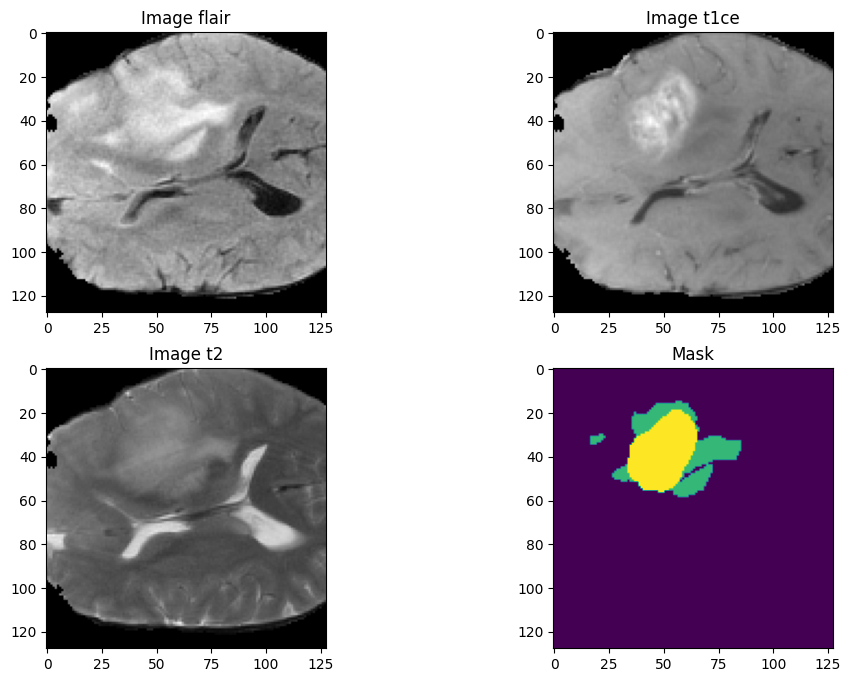

In [4]:
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

# Class Distribution Analysis 
This step calculates the distribution of each class in the dataset to determine appropriate class weights for handling class imbalance.

In [5]:
# Create dataframe to store class counts
columns = ['0', '1', '2', '3']
df = pd.DataFrame(columns=columns)

# Define the base path
base_path = r'C:\Users\arnav\Downloads\brain\BraTS2020_TrainingData\input_data_128\train\masks'

# Get all mask files
train_mask_list = sorted(glob.glob(os.path.join(base_path, '*.npy')))

print("Analyzing class distribution...")
for img in range(len(train_mask_list)):
    if img % 50 == 0:  # Progress indicator
        print(f"Processing image {img}/{len(train_mask_list)}")
    
    temp_image = np.load(train_mask_list[img])               # Shape: (128, 128, 128, 4)
    temp_image = np.argmax(temp_image, axis=3)               # Shape: (128, 128, 128)
    val, counts = np.unique(temp_image, return_counts=True)  # Class counts

    # Create dictionary for this image's class counts
    counts_dict = dict(zip(val.astype(str), counts))
    
    # Ensure all classes are represented (fill missing with 0)
    for col in columns:
        if col not in counts_dict:
            counts_dict[col] = 0
    
    # Append to DataFrame
    df = pd.concat([df, pd.DataFrame([counts_dict])], ignore_index=True)

print("Class distribution analysis complete!")

Analyzing class distribution...
Processing image 0/258
Processing image 50/258
Processing image 100/258
Processing image 150/258
Processing image 200/258
Processing image 250/258
Class distribution analysis complete!


Now let us calculate the class weights for training

In [6]:
label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['2'].sum()  
label_3 = df['3'].sum()

total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4

print(f"Class 0 (Background): {label_0:,} pixels")
print(f"Class 1 (Necrotic/Non-enhancing): {label_1:,} pixels")
print(f"Class 2 (Peritumoral edema): {label_2:,} pixels")
print(f"Class 3 (GD-enhancing): {label_3:,} pixels")

# Calculate class weights: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2)
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

print(f"\nCalculated class weights:")
print(f"Weight 0: {wt0}")
print(f"Weight 1: {wt1}")
print(f"Weight 2: {wt2}")
print(f"Weight 3: {wt3}")


Class 0 (Background): 515,098,764 pixels
Class 1 (Necrotic/Non-enhancing): 5,901,688 pixels
Class 2 (Peritumoral edema): 14,989,492 pixels
Class 3 (GD-enhancing): 5,075,272 pixels

Calculated class weights:
Weight 0: 0.26
Weight 1: 22.92
Weight 2: 9.02
Weight 3: 26.65


Define validation data directories and get file lists

In [7]:

val_img_dir = r"C:\Users\arnav\Downloads\brain\BraTS2020_TrainingData\input_data_128\val\images"
val_mask_dir = r"C:\Users\arnav\Downloads\brain\BraTS2020_TrainingData\input_data_128\val\masks"

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

print(f"Training images: {len(train_img_list)}")
print(f"Validation images: {len(val_img_list)}")

Training images: 258
Validation images: 86


Create the data generators

In [8]:
print("Loading training images...")
train_images = imageLoader(train_img_dir, train_img_list[:4])
print("Loading training masks...")
train_masks = imageLoader(train_mask_dir, train_mask_list[:4])


print("Loading validation images...")
val_images = imageLoader(val_img_dir, val_img_list[:4])
print("Loading validation masks...")
val_masks = imageLoader(val_mask_dir, val_mask_list[:4])

print(f"Training images shape: {train_images.shape}")
print(f"Training masks shape: {train_masks.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Validation masks shape: {val_masks.shape}")

# Verify data ranges
print(f"Training images ranage: {train_images.min():.3f} to {train_images.max():.3f}")
print(f"Training masks range: {train_masks.min():.3f} to {train_masks.max():.3f}")

Loading training images...
Loading training masks...
Loading validation images...
Loading validation masks...
Training images shape: (4, 128, 128, 128, 3)
Training masks shape: (4, 128, 128, 128, 4)
Validation images shape: (4, 128, 128, 128, 3)
Validation masks shape: (4, 128, 128, 128, 4)
Training images ranage: 0.000 to 1.000
Training masks range: 0.000 to 1.000


In [9]:
def train_img_datagen(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y)      

            batch_start += batch_size   
            batch_end += batch_size

Verify the generator and visualize a sample

Sample image shape: (128, 128, 128, 3)
Sample mask shape: (128, 128, 128)
Unique mask values: [0 1 2 3]


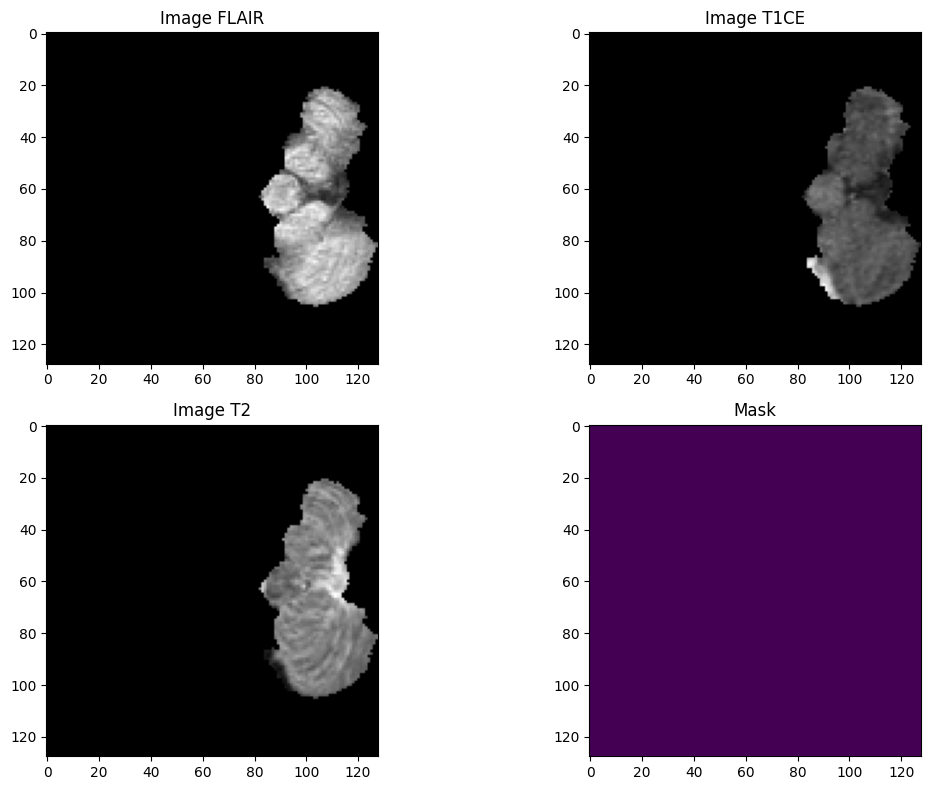

In [10]:
# Verify the loaded data by visualizing a sample
img_num = random.randint(0, len(train_images)-1)
test_img = train_images[img_num]
test_mask = train_masks[img_num]

# If masks are one-hot encoded, convert to class indices
if len(test_mask.shape) == 4 and test_mask.shape[-1] > 1:
    test_mask = np.argmax(test_mask, axis=3)

print(f"Sample image shape: {test_img.shape}")
print(f"Sample mask shape: {test_mask.shape}")
print(f"Unique mask values: {np.unique(test_mask)}")

n_slice = random.randint(0, test_mask.shape[2]-1)
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image FLAIR')

plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image T1CE')

plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image T2')

plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')

plt.tight_layout()
plt.show()

In [11]:
%run Unet_Model_3D.ipynb
# Now you can use simple_unet_model directly

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      1,312 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv3d[0][0]      │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │      6,928 │ dropout[0][0]     │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv3d_2[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     27,680 │ dropout_1[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv3d_4[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    110,656 │ dropout_2[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 16,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_2[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv3d_6[0][0]    │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 16, 16,    │    442,496 │ dropout_3[0][0]   │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 8, 8, 8,   │          0 │ conv3d_7[0][0]  

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


Now that we have tested this let us define the model and compile

We will Use calculated weights for this

In [12]:
import segmentation_models_3D as sm
# Define loss functions and metrics
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

# Define optimizer
LR = 0.0001
optim = keras.optimizers.Adam(LR)

print(f"Learning rate: {LR}")
print("Loss: Dice Loss + Focal Loss")
print("Metrics: Accuracy, IoU Score")

Segmentation Models: using `keras` framework.
Learning rate: 0.0001
Loss: Dice Loss + Focal Loss
Metrics: Accuracy, IoU Score


Let us define the loss function, netrics and the optimizer
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

print(f"Learning rate: {LR}")
print("Loss: Dice Loss + Focal Loss")
print("Metrics: Accuracy, IoU Score")

Now we calculate the training steps based on actual data size

In [13]:
batch_size = 2  # Adjust based on your GPU memory
steps_per_epoch = len(train_images) // batch_size
val_steps_per_epoch = len(val_images) // batch_size

print(f"Batch size: {batch_size}")
print(f"Training samples: {len(train_images)}")
print(f"Validation samples: {len(val_images)}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps per epoch: {val_steps_per_epoch}")

Batch size: 2
Training samples: 4
Validation samples: 4
Steps per epoch: 2
Validation steps per epoch: 2


Finally let us create and compile the model

We head to model training with the loaded data now that we have our unet model ready to go

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.metrics import categorical_accuracy, sparse_categorical_accuracy

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # Correct loss for one-hot encoded masks
    metrics=['accuracy', sm.metrics.IOUScore(threshold=0.5)]
)

print("Model recompiled for multi-class segmentation!")

Model recompiled for multi-class segmentation!


In [15]:
model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

print("Model compiled successfully!")
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 128, 128,  │      1,312 │ input_layer_1[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv3d_19[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 128, 128,  │      6,928 │ dropout_9[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 64, 64,    │          0 │ conv3d_20[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_4[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv3d_21[0][0]   │
│ (Dropout)           │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 64, 64,    │     27,680 │ dropout_10[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 32, 32,    │          0 │ conv3d_22[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_5[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv3d_23[0][0]   │
│ (Dropout)           │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 32, 32,    │    110,656 │ dropout_11[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 16, 16,    │          0 │ conv3d_24[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_6[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv3d_25[0][0]   │
│ (Dropout)           │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_26 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_12[0][0]  │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_7     │ (None, 8, 8, 8,   │          0 │ conv3d_26[0][0] 

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Model compiled successfully!
Input shape: (None, 128, 128, 128, 3)
Output shape: (None, 128, 128, 128, 4)


In [16]:
epochs = 50
batch_size = 1

print(f"Starting training for {epochs} epochs with correct loss function...")

history = model.fit(
    x=train_images,
    y=train_masks,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(val_images, val_masks),
    shuffle=True
)

print("Training completed!")

Starting training for 50 epochs with correct loss function...
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 76s 16s/step - accuracy: 0.2850 - iou_score: 0.0079 - loss: 0.8379 - val_accuracy: 0.2151 - val_iou_score: 0.0090 - val_loss: 0.7087
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 21s/step - accuracy: 0.3018 - iou_score: 0.0212 - loss: 0.7578 - val_accuracy: 0.2384 - val_iou_score: 0.0453 - val_loss: 0.7060
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 19s/step - accuracy: 0.3020 - iou_score: 0.0478 - loss: 0.6533 - val_accuracy: 0.2573 - val_iou_score: 0.0685 - val_loss: 0.7032
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 71s 19s/step - accuracy: 0.2894 - iou_score: 0.0472 - loss: 0.7667 - val_accuracy: 0.2731 - val_iou_score: 0.0730 - val_loss: 0.6980
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 74s 19s/step - accuracy: 0.3064 - iou_score: 0.0567 - loss: 0.7684 - val_accuracy: 0.2869 - val_iou_score: 0.0748 - val_loss: 0.6888
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 22s/step - accuracy: 0.3194 - iou_score: 0.0473 - los

# Plot training and validation loss

Model achieved ~91% training accuracy and ~95.5% validation accuracy.
Indicates strong generalization and effective learning.
Further training or hyperparameter tuning could improve training performance to match validation.


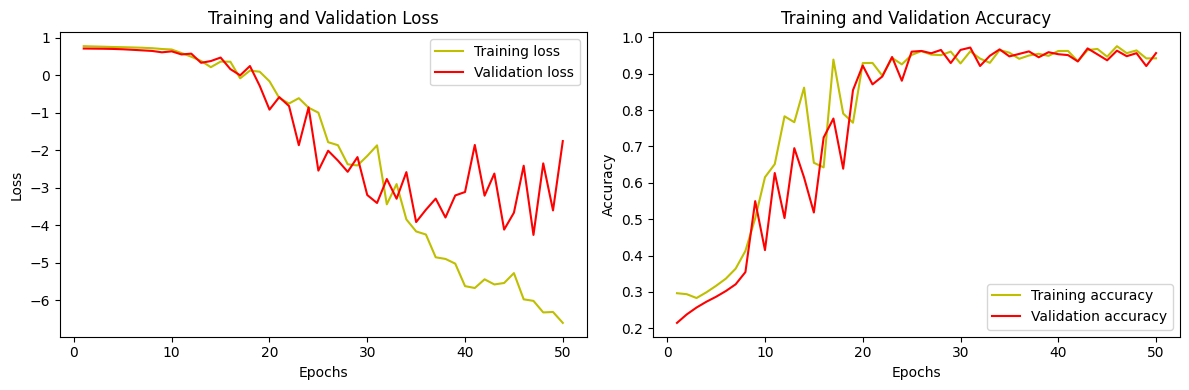

In [17]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'y', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, 'y', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()